# Fighting 3D CNN

In [4]:
# Cell 1

!pip install -q keras-tuner
import json
import shutil
from datetime import datetime
import pickle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)
import os


In [5]:
import shutil
if os.path.exists('/content/drive'):
    shutil.rmtree('/content/drive')

Data loading and processing

In [6]:
# Cell 2
# Dataset Loading & Processing
import cv2
import numpy as np
from google.colab import drive
import random
from sklearn.utils import shuffle
from collections import Counter
drive.mount('/content/drive')

IMG_SIZE = 64 # 64x64 pixels
FRAMES_PER_VIDEO = 16 #
DATASET_PATH = '/content/drive/MyDrive/UBI_FIGHTS/videos'

# Add these new global variables
MODEL_VERSIONS_PATH = '/content/drive/MyDrive/model_versions'
RETRAIN_DATA_PATH = '/content/drive/MyDrive/retrain_data'
MODEL_METADATA_PATH = '/content/drive/MyDrive/model_metadata.json'

# Create directories if they don't exist
os.makedirs(MODEL_VERSIONS_PATH, exist_ok=True)
os.makedirs(RETRAIN_DATA_PATH, exist_ok=True)
os.makedirs(os.path.join(RETRAIN_DATA_PATH, 'fight'), exist_ok=True)
os.makedirs(os.path.join(RETRAIN_DATA_PATH, 'normal'), exist_ok=True)

print("✅ Drive mounted and directories created")

def augment_frames(frames): # editing light, shape,
    augmented = frames.copy()

    if random.random() > 0.5:
        augmented = np.flip(augmented, axis=2)

    if random.random() > 0.5:
        brightness_factor = random.uniform(0.8, 1.2)
        augmented = np.clip(augmented * brightness_factor, 0, 255)

    if random.random() > 0.7:
        angle = random.uniform(-5, 5)
        for i in range(len(augmented)):
            center = (IMG_SIZE // 2, IMG_SIZE // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            augmented[i] = cv2.warpAffine(augmented[i], rotation_matrix, (IMG_SIZE, IMG_SIZE))

    return augmented.astype(np.uint8)

def extract_frames(video_path, max_frames=FRAMES_PER_VIDEO):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < max_frames:
        step = 1
    else:
        step = total_frames // max_frames

    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frames.append(frame)

        if len(frames) == max_frames:
            break

    cap.release()

    while len(frames) < max_frames:
        if frames:
            frames.append(frames[-1])
        else:
            frames.append(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8))

    return np.array(frames[:max_frames])

if os.path.exists(DATASET_PATH):
    print(f"Dataset found at {DATASET_PATH}")

    X, y = [], []
# video = normal & fight
    folder_mapping = {'normal': 0, 'fight': 1} # cnn = sigmoid

                        # x  = 0    ,     # y = 1

    for folder, label in folder_mapping.items():
        folder_path = os.path.join(DATASET_PATH, folder)

        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} not found")
            continue

        video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi', '.mov'))]
        print(f"Processing {len(video_files)} videos from '{folder}' folder...")
# 100 %50 = print
        for i, video_file in enumerate(video_files):
            if i % 50 == 0:
                print(f"  Processing video {i+1}/{len(video_files)}")

            video_path = os.path.join(folder_path, video_file)
            frames = extract_frames(video_path)

            X.append(frames)
            y.append(label)

            if random.random() > 0.7:
                augmented_frames = augment_frames(frames)
                X.append(augmented_frames)
                y.append(label)

    X = np.array(X) # normal
    y = np.array(y) # fight

    X, y = shuffle(X, y, random_state=42) # shuffling 00000000 , 1111111 = 010101010101

    print(f"\nTotal videos: {len(X)}")
    print(f"Input shape: {X.shape}")
    print(f"Class distribution: {Counter(y)}")
    print(f"   - Normal (no-fight): {np.sum(y == 0)}")
    print(f"   - Fight: {np.sum(y == 1)}")
    print("Do with this")

else:
    print(f"Dataset not found at {DATASET_PATH}")

Mounted at /content/drive
✅ Drive mounted and directories created
Dataset found at /content/drive/MyDrive/UBI_FIGHTS/videos
Processing 784 videos from 'normal' folder...
  Processing video 1/784
  Processing video 51/784
  Processing video 101/784
  Processing video 151/784
  Processing video 201/784
  Processing video 251/784
  Processing video 301/784
  Processing video 351/784
  Processing video 401/784
  Processing video 451/784
  Processing video 501/784
  Processing video 551/784
  Processing video 601/784
  Processing video 651/784
  Processing video 701/784
  Processing video 751/784
Processing 216 videos from 'fight' folder...
  Processing video 1/216
  Processing video 51/216
  Processing video 101/216
  Processing video 151/216
  Processing video 201/216

Total videos: 1301
Input shape: (1301, 16, 64, 64, 3)
Class distribution: Counter({np.int64(0): 1025, np.int64(1): 276})
   - Normal (no-fight): 1025
   - Fight: 276
Do with this


Data spiliting into test, training, validation data

In [7]:
# Cell 3

# training, test, validation = 60%, 20%, 20%

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

X = X.astype(np.float32) / 255.0

lb = LabelBinarizer()
y = lb.fit_transform(y).flatten()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train class distribution: {Counter(y_train)}")
print(f"Val class distribution: {Counter(y_val)}")
print(f"Test class distribution: {Counter(y_test)}")
print("Done with data splitting!")

Training set: 780 samples
Validation set: 260 samples
Test set: 261 samples
Train class distribution: Counter({np.int64(0): 615, np.int64(1): 165})
Val class distribution: Counter({np.int64(0): 205, np.int64(1): 55})
Test class distribution: Counter({np.int64(0): 205, np.int64(1): 56})
Done with data splitting!


Define model architecture and Create Model

In [8]:
# Cell 4

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, Dense, Dropout, Flatten,
    BatchNormalization, Input, GlobalAveragePooling3D
)
from tensorflow.keras.regularizers import l2
!pip install -q keras-tuner
import keras_tuner as kt

def create_optimized_model(hp):
    model = Sequential()
    model.add(Input(shape=(FRAMES_PER_VIDEO, IMG_SIZE, IMG_SIZE, 3))) # 3 :  16, 64, 3

    model.add(Conv3D(
        filters=hp.Int('filters_1', 16, 32, step=8),
        kernel_size=(3, 3, 3),
        activation='relu', # Renuct Linear Unit
        kernel_regularizer=l2(hp.Float('l2_1', 1e-5, 1e-3, sampling='LOG'))
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.4, step=0.1)))

    model.add(Conv3D(
        filters=hp.Int('filters_2', 32, 64, step=16),
        kernel_size=(3, 3, 3),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_2', 1e-5, 1e-3, sampling='LOG'))
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(hp.Float('dropout_2', 0.3, 0.5, step=0.1)))

    if hp.Boolean('use_third_conv'):
        model.add(Conv3D(
            filters=hp.Int('filters_3', 64, 96, step=16),
            kernel_size=(3, 3, 3),
            activation='relu',
            kernel_regularizer=l2(hp.Float('l2_3', 1e-5, 1e-3, sampling='LOG'))
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(hp.Float('dropout_3', 0.3, 0.5, step=0.1)))

    model.add(GlobalAveragePooling3D())

    model.add(Dense(
        units=hp.Int('dense_units', 64, 128, step=32),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_dense', 1e-5, 1e-3, sampling='LOG'))
    ))
    model.add(Dropout(hp.Float('dropout_dense', 0.4, 0.6, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall'] # acc= 40% , precise ,  recall
    )

    return model

print("done with this")

done with this


In [9]:
# Cell 5

# use best hyperparams / settings

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

print("Creating subset for faster tuning...")
subset_size = int(len(X_train) * 0.3)
indices = np.random.choice(len(X_train), subset_size, replace=False)
X_tune = X_train[indices]
y_tune = y_train[indices]

val_subset_size = int(len(X_val) * 0.3)
val_indices = np.random.choice(len(X_val), val_subset_size, replace=False)
X_val_tune = X_val[val_indices]
y_val_tune = y_val[val_indices]

print(f"Tuning with {len(X_tune)} training samples instead of {len(X_train)}")

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(FRAMES_PER_VIDEO, IMG_SIZE, IMG_SIZE, 3)))

    model.add(Conv3D(
        filters=hp.Choice('filters_1', [16, 24, 32]),
        kernel_size=(3, 3, 3),
        activation='relu',
        kernel_regularizer=l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv3D(
        filters=hp.Choice('filters_2', [32, 48, 64]),
        kernel_size=(3, 3, 3),
        activation='relu',
        kernel_regularizer=l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.4))

    if hp.Boolean('use_third_conv'):
        model.add(Conv3D(
            filters=64,
            kernel_size=(3, 3, 3),
            activation='relu',
            kernel_regularizer=l2(0.001)
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.4))

    model.add(GlobalAveragePooling3D())
    model.add(Dense(
        units=hp.Choice('dense_units', [64, 128]),
        activation='relu',
        kernel_regularizer=l2(0.001)
    ))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    directory='tuner_logs_simple',
    project_name='fight_classification_simple',
    overwrite=True
)

tuning_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_lr=1e-6,
        verbose=1
    )
]

print("hyperparameter tuning")
tuner.search(
    X_tune, y_tune,
    epochs=6,
    validation_data=(X_val_tune, y_val_tune),
    batch_size=8,
    callbacks=tuning_callbacks,
    verbose=1
)

print("\nBest hyperparameters:")
best_hps = tuner.get_best_hyperparameters(1)[0]
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

best_model = tuner.get_best_models(1)[0]
best_model.summary()

print("Done with this")

Trial 3 Complete [00h 00m 23s]
val_accuracy: 0.8589743375778198

Best val_accuracy So Far: 0.8589743375778198
Total elapsed time: 00h 01m 25s

Best hyperparameters:
filters_1: 24
filters_2: 64
use_third_conv: True
dense_units: 128
learning_rate: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 14, 62, 62, 24) │         1,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 62, 62, 24) │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 14, 31, 31, 24) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 31, 31, 24) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 12, 29, 29, 64) │        41,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 29, 29, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 6, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 12, 12, 64)  │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 12, 12, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 6, 6, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 6, 6, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,217 (637.57 KB)

 Trainable params: 162,913 (636.38 KB)

 Non-trainable params: 304 (1.19 KB)

Done with this


In [10]:
# Cell 6

# Training with callbacks like es

from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from sklearn.utils.class_weight import compute_class_weight
import os

class_weights = compute_class_weight(
    class_weight='balanced', # 60% balanced = 100 n f 60
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class weights: {class_weight_dict}")

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-7,
        verbose=1,
        cooldown=1
    ),
    ModelCheckpoint(
        filepath='/content/drive/MyDrive/best_fight_model_checkpoint.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print("training best model.")

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=4,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("done with this")

Class weights: {0: np.float64(0.6341463414634146), 1: np.float64(2.3636363636363638)}
training best model.
Epoch 1/30
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7896 - loss: 0.7231 - precision: 0.4646 - recall: 0.5788
Epoch 1: val_accuracy improved from -inf to 0.26923, saving model to /content/drive/MyDrive/best_fight_model_checkpoint.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.7895 - loss: 0.7228 - precision: 0.4648 - recall: 0.5800 - val_accuracy: 0.2692 - val_loss: 1.1375 - val_precision: 0.2245 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 2/30
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8167 - loss: 0.6285 - precision: 0.5371 - recall: 0.7281
Epoch 2: val_accuracy improved from 0.26923 to 0.85000, saving model to /content/drive/MyDrive/best_fight_model_checkpoint.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8169 - loss: 0.6281 - precision: 0.5376 - recall: 0.7288 - val_accuracy: 0.8500 - val_loss: 0.5740 - val_precision: 0.6081 - val_recall: 0.8182 - learning_rate: 5.0000e-04
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8382 - loss: 0.5649 - precision: 0.5478 - recall: 0.7873
Epoch 3: val_accuracy improved from 0.85000 to 0.88462, saving model to /content/drive/MyDrive/best_fight_model_checkpoint.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8382 - loss: 0.5651 - precision: 0.5480 - recall: 0.7873 - val_accuracy: 0.8846 - val_loss: 0.4701 - val_precision: 0.7119 - val_recall: 0.7636 - learning_rate: 5.0000e-04
Epoch 4/30
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8757 - loss: 0.5373 - precision: 0.6745 - recall: 0.8297
Epoch 4: val_accuracy improved from 0.88462 to 0.90385, saving model to /content/drive/MyDrive/best_fight_model_checkpoint.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8757 - loss: 0.5372 - precision: 0.6743 - recall: 0.8296 - val_accuracy: 0.9038 - val_loss: 0.4632 - val_precision: 0.8000 - val_recall: 0.7273 - learning_rate: 5.0000e-04
Epoch 5/30
192/195 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8824 - loss: 0.5131 - precision: 0.7070 - recall: 0.7650
Epoch 5: val_accuracy did not improve from 0.90385
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8821 - loss: 0.5132 - precision: 0.7061 - recall: 0.7650 - val_accuracy: 0.8538 - val_loss: 0.5972 - val_precision: 0.9048 - val_recall: 0.3455 - learning_rate: 5.0000e-04
Epoch 6/30
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8884 - loss: 0.4656 - precision: 0.6420 - recall: 0.8361
Epoch 6: val_accuracy did not improve from 0.90385
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8884 - loss: 0.4661 - precision: 0.6429 - recall: 0.8359 - val_accuracy: 0.8577 - val_loss: 0.4888 - val_precision: 0.6184 - val_recall: 0

195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9014 - loss: 0.4479 - precision: 0.7476 - recall: 0.8680 - val_accuracy: 0.9231 - val_loss: 0.3734 - val_precision: 0.8182 - val_recall: 0.8182 - learning_rate: 1.5000e-04
Epoch 10/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9284 - loss: 0.4008 - precision: 0.7903 - recall: 0.8740
Epoch 10: val_accuracy did not improve from 0.92308
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9282 - loss: 0.4010 - precision: 0.7901 - recall: 0.8739 - val_accuracy: 0.6308 - val_loss: 0.8129 - val_precision: 0.3624 - val_recall: 0.9818 - learning_rate: 1.5000e-04
Epoch 11/30
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9260 - loss: 0.3602 - precision: 0.7868 - recall: 0.9154
Epoch 11: val_accuracy did not improve from 0.92308
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9260 - loss: 0.3609 - precision: 0.7869 - recall: 0.9144 - val_accuracy: 0.8115 - val_loss: 0.5656 - val_precision: 0.5306 - val_recal

Evaluation model

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
Validation Metrics
Accuracy  : 0.9231
Precision : 0.8182
Recall    : 0.8182
F1-Score  : 0.8182
AUC-ROC   : 0.9478
Test Metrics
Accuracy  : 0.9157
Precision : 0.8696
Recall    : 0.7143
F1-Score  : 0.7843
AUC-ROC   : 0.9359
Classification Report
Validation Set:
              precision    recall  f1-score   support

     noFight       0.95      0.95      0.95       205
       fight       0.82      0.82      0.82        55

    accuracy                           0.92       260
   macro avg       0.88      0.88      0.88       260
weighted avg       0.92      0.92      0.92       260


Test Set:
              precision    recall  f1-score   support

     noFight       0.93      0.97      0.95       205
       fight       0.87      0.71      0.78        56

    accuracy                           0.92       261
   macro avg       0.90      0.84      0.87       261
weighted avg       0.91      0.92      0.91       261

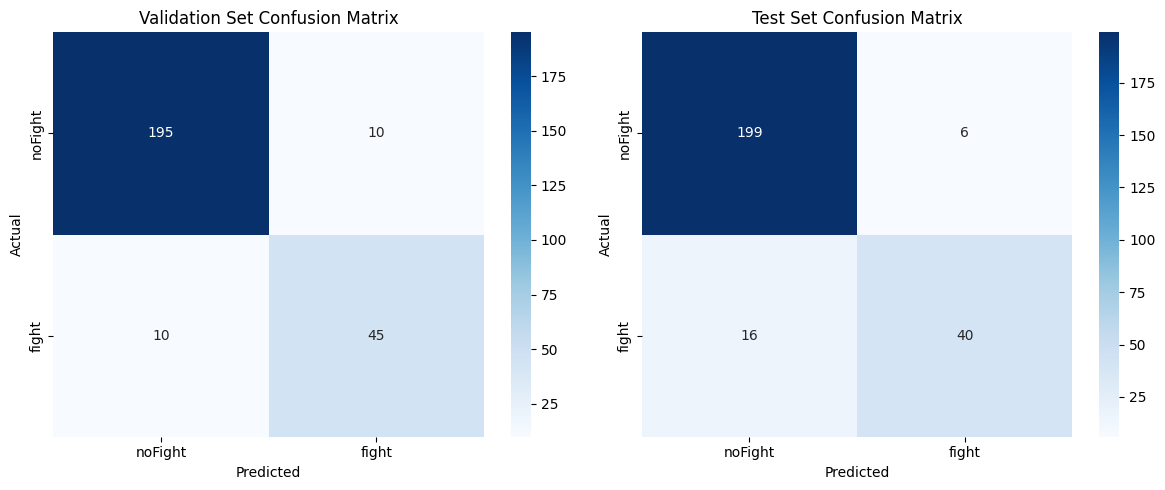

done with this


In [11]:
# Cell 7

#  Model Evaluation (Kinda too much but meh)

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

y_val_pred_probs = best_model.predict(X_val)
y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()

y_test_pred_probs = best_model.predict(X_test)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

def calculate_metrics(y_true, y_pred, y_pred_probs, set_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)

    print(f"{set_name} Metrics")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-Score  : {f1:.4f}")
    print(f"AUC-ROC   : {auc:.4f}")

    return accuracy, precision, recall, f1, auc

val_metrics = calculate_metrics(y_val, y_val_pred, y_val_pred_probs.flatten(), "Validation")
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_probs.flatten(), "Test")

print(f"Classification Report")
print("Validation Set:")
print(classification_report(y_val, y_val_pred, target_names=['noFight', 'fight']))
print("\nTest Set:")
print(classification_report(y_test, y_test_pred, target_names=['noFight', 'fight']))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', ax=axes[0],
            xticklabels=['noFight', 'fight'], # normal #fight = noFight , Fight
            yticklabels=['noFight', 'fight'], cmap='Blues')
axes[0].set_title('Validation Set Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1],
            xticklabels=['noFight', 'fight'],
            yticklabels=['noFight', 'fight'], cmap='Blues')
axes[1].set_title('Test Set Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

print("done with this")

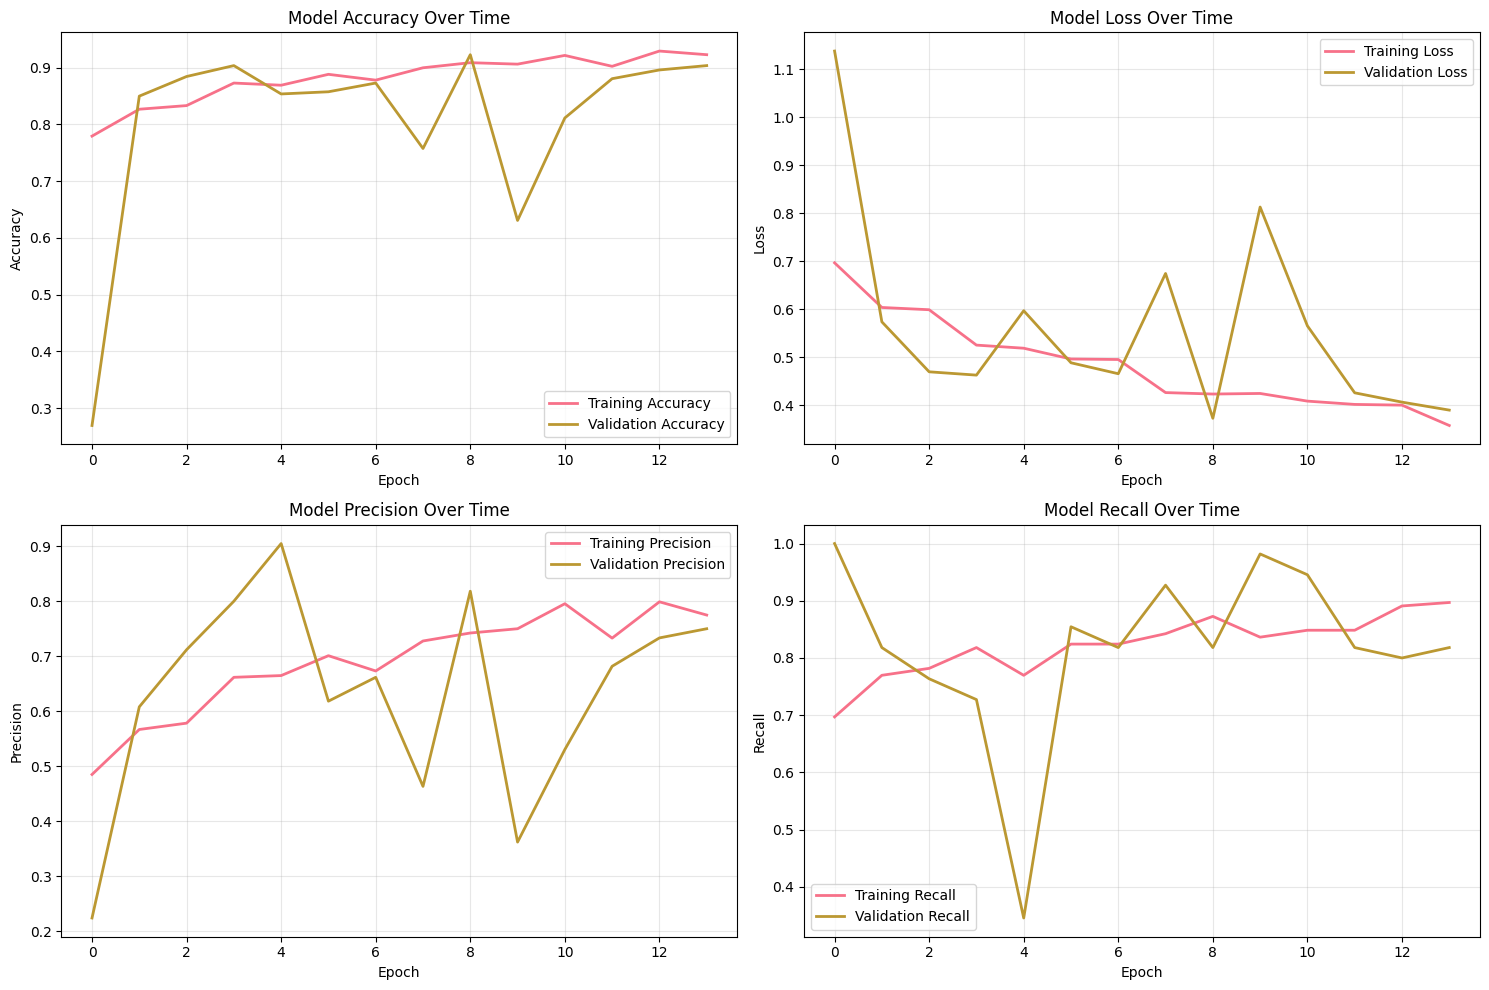

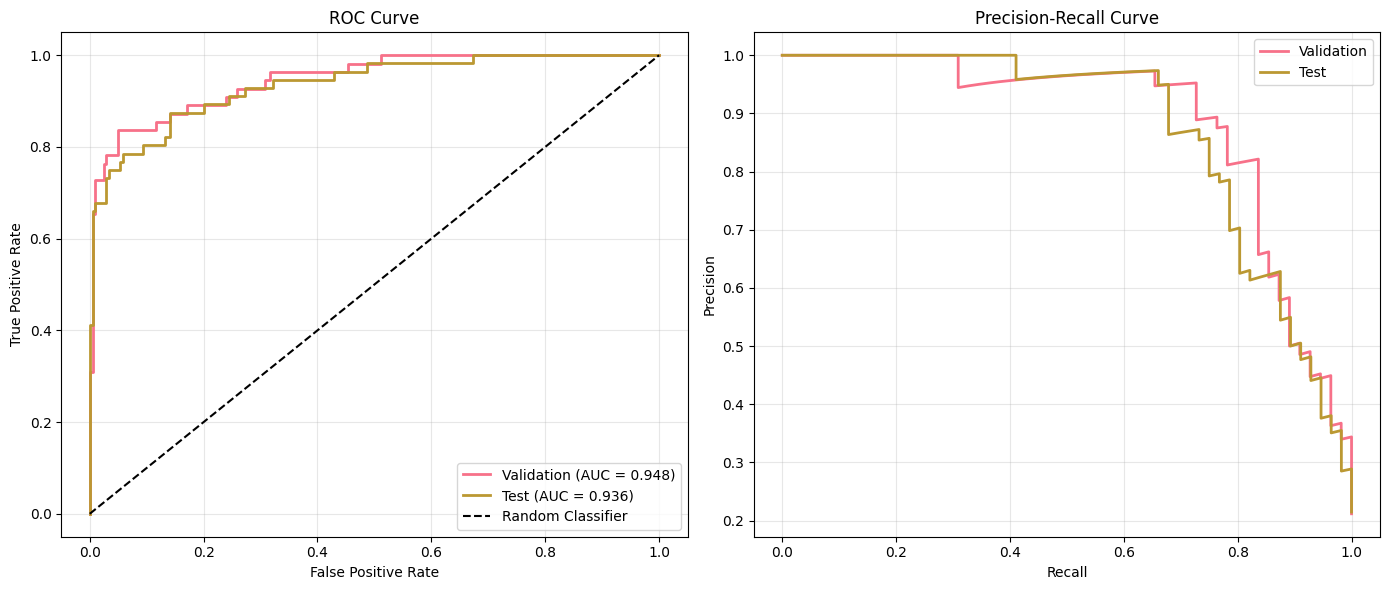

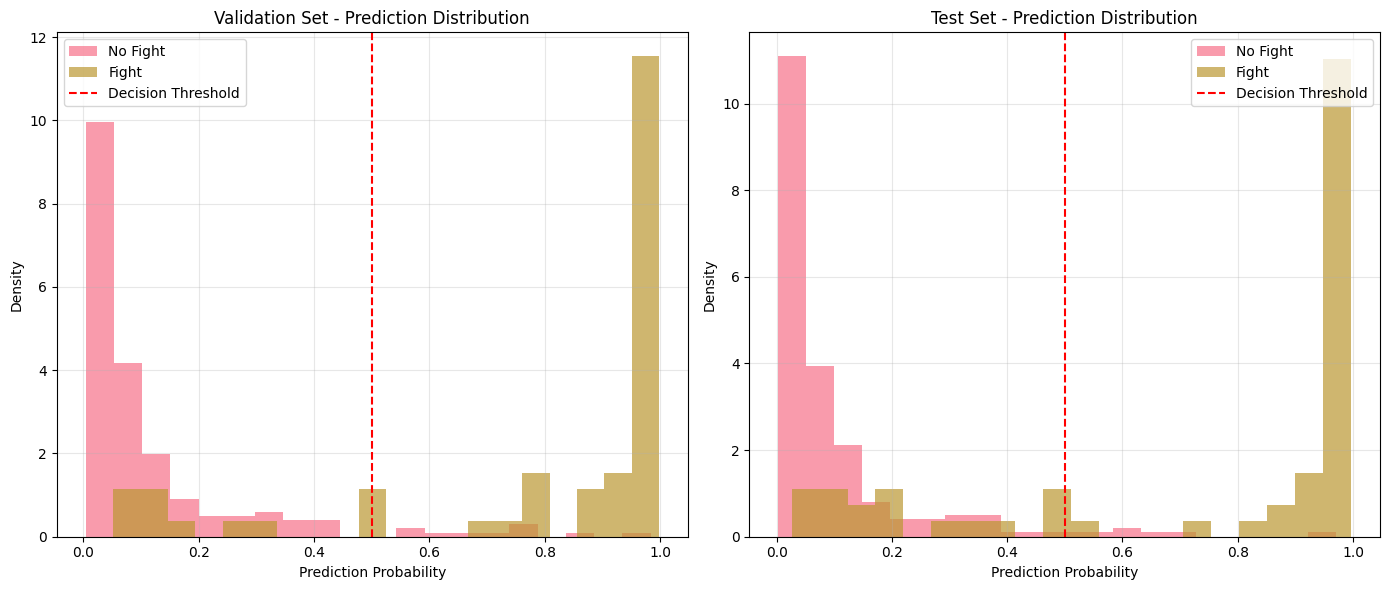

Done here


In [12]:
# Cell 8

# Visualizations and analysis

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve
import numpy as np

plt.style.use('default')
sns.set_palette("husl")

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy Over Time')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss Over Time')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
        axes[1, 0].set_title('Model Precision Over Time')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
        axes[1, 1].set_title('Model Recall Over Time')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_roc_and_pr_curves():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_probs)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_probs)

    axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {roc_auc_score(y_val, y_val_pred_probs):.3f})', linewidth=2)
    axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {roc_auc_score(y_test, y_test_pred_probs):.3f})', linewidth=2)
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_probs)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_probs)

    axes[1].plot(recall_val, precision_val, label='Validation', linewidth=2)
    axes[1].plot(recall_test, precision_test, label='Test', linewidth=2)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_prediction_distribution():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].hist(y_val_pred_probs[y_val == 0], bins=20, alpha=0.7, label='No Fight', density=True)
    axes[0].hist(y_val_pred_probs[y_val == 1], bins=20, alpha=0.7, label='Fight', density=True)
    axes[0].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
    axes[0].set_xlabel('Prediction Probability')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Validation Set - Prediction Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].hist(y_test_pred_probs[y_test == 0], bins=20, alpha=0.7, label='No Fight', density=True)
    axes[1].hist(y_test_pred_probs[y_test == 1], bins=20, alpha=0.7, label='Fight', density=True)
    axes[1].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
    axes[1].set_xlabel('Prediction Probability')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Test Set - Prediction Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

plot_roc_and_pr_curves()

plot_prediction_distribution()

print("Done here")

In [13]:
# Cell 9

# save best model and prediction function

import tensorflow as tf
import numpy as np
import cv2

MODEL_PATH = 'fight_detection_model_optimized.h5'
best_model.save(MODEL_PATH)
print(f"✅ Optimized model saved to {MODEL_PATH}")

# Save initial model metadata
initial_model_info = {
    'version': 'initial_' + datetime.now().strftime("%Y%m%d_%H%M%S"),
    'model_path': MODEL_PATH,
    'training_date': datetime.now().isoformat(),
    'data_used': {
        'fight_videos': int(np.sum(y == 1)),
        'normal_videos': int(np.sum(y == 0)),
        'total_videos': int(len(y))
    },
    'performance': {
        'accuracy': float(test_metrics[0]),
        'precision': float(test_metrics[1]),
        'recall': float(test_metrics[2]),
        'f1_score': float(test_metrics[3])
    },
    'transfer_learning': False,
    'base_model': None
}

# Save metadata function (add this function before using it)
def save_model_metadata(model_info):
    """Save model training metadata"""
    try:
        if os.path.exists(MODEL_METADATA_PATH):
            with open(MODEL_METADATA_PATH, 'r') as f:
                metadata = json.load(f)
        else:
            metadata = {'models': []}

        metadata['models'].append(model_info)

        with open(MODEL_METADATA_PATH, 'w') as f:
            json.dump(metadata, f, indent=2)

        print(f"✅ Model metadata saved")
    except Exception as e:
        print(f"❌ Error saving metadata: {e}")

save_model_metadata(initial_model_info)
print(f"✅ Initial model metadata saved")

def predict_video(video_path, model, threshold=0.5, verbose=True):

    try:
        frames = extract_frames(video_path, FRAMES_PER_VIDEO)

        if frames.shape[0] != FRAMES_PER_VIDEO:
            return {
                'error': f"Could not extract {FRAMES_PER_VIDEO} frames",
                'frames_extracted': frames.shape[0]
            }

        input_array = np.expand_dims(frames.astype(np.float32) / 255.0, axis=0)

        prediction_prob = model.predict(input_array, verbose=0)[0][0]
        prediction_label = "fight" if prediction_prob > threshold else "noFight"

        confidence_score = max(prediction_prob, 1 - prediction_prob)
        if confidence_score > 0.8:
            confidence_level = "High"
        elif confidence_score > 0.6:
            confidence_level = "Medium"
        else:
            confidence_level = "Low"

        result = {
            'prediction': prediction_label, # noFight Fight
            'probability': float(prediction_prob),
            'confidence_score': float(confidence_score),
            'confidence_level': confidence_level,  # High Low
            'threshold_used': threshold # 1, 0.5
        }

        if verbose:
            print(f"🎯 Prediction: {prediction_label}")
            print(f"📊 Probability: {prediction_prob:.4f}")
            print(f"🎚️ Confidence: {confidence_level} ({confidence_score:.4f})")

        return result

    except Exception as e:
        return {'error': f"Prediction failed: {str(e)}"}

def batch_predict_videos(video_paths, model, threshold=0.5):

# go through multiple videos at once

    results = []
    for i, video_path in enumerate(video_paths):
        print(f"\nProcessing video {i+1}/{len(video_paths)}: {video_path}")
        result = predict_video(video_path, model, threshold, verbose=True)
        results.append(result)
    return results

print("Done with this")

✅ Optimized model saved to fight_detection_model_optimized.h5
✅ Model metadata saved
✅ Initial model metadata saved
Done with this


In [14]:
# Cell 10 - Retraining Functions

def validate_retrain_data(fight_path, normal_path, min_files_per_class=50):
    """Validate uploaded retraining data"""

    fight_files = [f for f in os.listdir(fight_path) if f.endswith(('.mp4', '.avi', '.mov'))]
    normal_files = [f for f in os.listdir(normal_path) if f.endswith(('.mp4', '.avi', '.mov'))]

    total_files = len(fight_files) + len(normal_files)

    validation_result = {
        'valid': False,
        'fight_count': len(fight_files),
        'normal_count': len(normal_files),
        'total_count': total_files,
        'errors': []
    }

    # Check minimum total files (100)
    if total_files < 100:
        validation_result['errors'].append(f"Need at least 100 total files, got {total_files}")

    # Check minimum files per class
    if len(fight_files) < min_files_per_class:
        validation_result['errors'].append(f"Need at least {min_files_per_class} fight videos, got {len(fight_files)}")

    if len(normal_files) < min_files_per_class:
        validation_result['errors'].append(f"Need at least {min_files_per_class} normal videos, got {len(normal_files)}")

    # Check class balance (shouldn't be too imbalanced)
    if total_files > 0:
        fight_ratio = len(fight_files) / total_files
        if fight_ratio < 0.2 or fight_ratio > 0.8:
            validation_result['errors'].append(f"Class imbalance detected. Fight ratio: {fight_ratio:.2f}. Should be between 0.2-0.8")

    validation_result['valid'] = len(validation_result['errors']) == 0

    return validation_result

def load_retrain_data(retrain_data_path):
    """Load and process retraining data"""
    print("🔄 Loading retraining data...")

    X_retrain, y_retrain = [], []
    folder_mapping = {'normal': 0, 'fight': 1}

    for folder, label in folder_mapping.items():
        folder_path = os.path.join(retrain_data_path, folder)

        if not os.path.exists(folder_path):
            print(f"⚠️ Warning: Folder {folder_path} not found")
            continue

        video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi', '.mov'))]
        print(f"📁 Processing {len(video_files)} videos from '{folder}' folder...")

        for i, video_file in enumerate(video_files):
            if i % 25 == 0:
                print(f"  Processing video {i+1}/{len(video_files)}")

            video_path = os.path.join(folder_path, video_file)
            try:
                frames = extract_frames(video_path)
                X_retrain.append(frames)
                y_retrain.append(label)

                # Add augmentation for retraining data
                if random.random() > 0.6:  # 40% chance for augmentation
                    augmented_frames = augment_frames(frames)
                    X_retrain.append(augmented_frames)
                    y_retrain.append(label)

            except Exception as e:
                print(f"❌ Error processing {video_file}: {e}")
                continue

    if len(X_retrain) == 0:
        return None, None

    X_retrain = np.array(X_retrain)
    y_retrain = np.array(y_retrain)

    # Shuffle the data
    X_retrain, y_retrain = shuffle(X_retrain, y_retrain, random_state=42)

    print(f"✅ Loaded {len(X_retrain)} retraining samples")
    print(f"📊 Class distribution: {Counter(y_retrain)}")

    return X_retrain, y_retrain

def create_retrain_model(input_shape, base_model=None):
    """Create model for retraining (either from scratch or transfer learning)"""

    if base_model is not None:
        print("🔄 Using transfer learning from existing model...")
        # Clone the model architecture
        model = tf.keras.models.clone_model(base_model)
        model.build(input_shape)

        # Copy weights from base model (all layers except the last dense layer)
        for i, layer in enumerate(model.layers[:-1]):  # Exclude last layer
            if i < len(base_model.layers) - 1:
                layer.set_weights(base_model.layers[i].get_weights())

        # Freeze early layers for transfer learning
        for layer in model.layers[:-3]:  # Freeze all but last 3 layers
            layer.trainable = False

    else:
        print("🔨 Creating new model from scratch...")
        # Use your existing best hyperparameters
        model = Sequential()
        model.add(Input(shape=input_shape[1:]))  # Remove batch dimension

        model.add(Conv3D(filters=24, kernel_size=(3, 3, 3), activation='relu',
                        kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))
        model.add(Dropout(0.3))

        model.add(Conv3D(filters=48, kernel_size=(3, 3, 3), activation='relu',
                        kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.4))

        model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu',
                        kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.4))

        model.add(GlobalAveragePooling3D())
        model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

    # Compile model with lower learning rate for fine-tuning
    learning_rate = 0.0001 if base_model is not None else 0.001

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

print("✅ Retraining functions loaded")

✅ Retraining functions loaded


In [15]:
# Cell 11 - Main Retraining Function

def retrain_model(retrain_data_path, base_model_path=None, use_transfer_learning=True):
    """Main retraining function"""

    print("🚀 Starting model retraining process...")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Step 1: Validate retraining data
    fight_path = os.path.join(retrain_data_path, 'fight')
    normal_path = os.path.join(retrain_data_path, 'normal')

    validation = validate_retrain_data(fight_path, normal_path)

    if not validation['valid']:
        print("❌ Data validation failed:")
        for error in validation['errors']:
            print(f"   - {error}")
        return None

    print("✅ Data validation passed:")
    print(f"   - Fight videos: {validation['fight_count']}")
    print(f"   - Normal videos: {validation['normal_count']}")
    print(f"   - Total videos: {validation['total_count']}")

    # Step 2: Load retraining data
    X_retrain, y_retrain = load_retrain_data(retrain_data_path)

    if X_retrain is None:
        print("❌ Failed to load retraining data")
        return None

    # Step 3: Load existing model if available
    base_model = None

    if use_transfer_learning and base_model_path and os.path.exists(base_model_path):
        try:
            print("📥 Loading existing model for transfer learning...")
            base_model = tf.keras.models.load_model(base_model_path)

        except Exception as e:
            print(f"⚠️ Could not load base model: {e}")
            print("🔄 Training from scratch instead...")

    # Step 4: Prepare data
    X_retrain = X_retrain.astype(np.float32) / 255.0

    # Label binarization
    lb = LabelBinarizer()
    y_retrain = lb.fit_transform(y_retrain).flatten()

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_retrain, y_retrain, test_size=0.4, stratify=y_retrain, random_state=42
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    print(f"📊 Data split:")
    print(f"   - Training: {X_train.shape[0]} samples")
    print(f"   - Validation: {X_val.shape[0]} samples")
    print(f"   - Test: {X_test.shape[0]} samples")

    # Step 5: Create and train model
    input_shape = X_train.shape
    retrained_model = create_retrain_model(input_shape, base_model)

    # Calculate class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Callbacks for retraining
    retrain_callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Train the model
    print("🏋️ Training retrained model...")
    epochs = 15 if use_transfer_learning else 25

    history = retrained_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=4,
        callbacks=retrain_callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )

    # Step 6: Evaluate retrained model
    print("📊 Evaluating retrained model...")

    y_test_pred_probs = retrained_model.predict(X_test)
    y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print(f"✅ Retrained Model Performance:")
    print(f"   - Accuracy: {test_accuracy:.4f}")
    print(f"   - Precision: {test_precision:.4f}")
    print(f"   - Recall: {test_recall:.4f}")
    print(f"   - F1-Score: {test_f1:.4f}")

    # Step 7: Save retrained model
    retrained_model_path = os.path.join(MODEL_VERSIONS_PATH, f'fight_model_retrained_{timestamp}.h5')
    retrained_model.save(retrained_model_path)

    # Save model metadata
    model_info = {
        'version': timestamp,
        'model_path': retrained_model_path,
        'training_date': datetime.now().isoformat(),
        'data_used': {
            'fight_videos': validation['fight_count'],
            'normal_videos': validation['normal_count'],
            'total_videos': validation['total_count']
        },
        'performance': {
            'accuracy': float(test_accuracy),
            'precision': float(test_precision),
            'recall': float(test_recall),
            'f1_score': float(test_f1)
        },
        'transfer_learning': use_transfer_learning,
        'base_model': base_model_path if base_model_path else None
    }

    save_model_metadata(model_info)

    print(f"💾 Retrained model saved to: {retrained_model_path}")

    return {
        'model': retrained_model,
        'model_path': retrained_model_path,
        'performance': model_info['performance'],
        'history': history
    }

print("✅ Main retraining function loaded")

✅ Main retraining function loaded


In [16]:
# Cell 12 - Frontend Interface Functions

def trigger_retraining(retrain_data_path=RETRAIN_DATA_PATH, use_existing_model=True):
    """Function to trigger retraining from frontend"""

    try:
        # Determine base model path
        base_model_path = None
        if use_existing_model:
            # Load the most recent model
            if os.path.exists(MODEL_METADATA_PATH):
                with open(MODEL_METADATA_PATH, 'r') as f:
                    metadata = json.load(f)
                if metadata['models']:
                    base_model_path = metadata['models'][-1]['model_path']

            # Fallback to the original model
            if not base_model_path or not os.path.exists(base_model_path):
                base_model_path = 'fight_detection_model_optimized.h5'

        # Start retraining
        result = retrain_model(
            retrain_data_path=retrain_data_path,
            base_model_path=base_model_path,
            use_transfer_learning=use_existing_model
        )

        if result:
            return {
                'success': True,
                'message': 'Model retrained successfully!',
                'model_path': result['model_path'],
                'performance': result['performance']
            }
        else:
            return {
                'success': False,
                'message': 'Retraining failed. Check the data and try again.'
            }

    except Exception as e:
        return {
            'success': False,
            'message': f'Retraining error: {str(e)}'
        }

def check_retrain_data_status():
    """Check if enough data is available for retraining"""
    fight_path = os.path.join(RETRAIN_DATA_PATH, 'fight')
    normal_path = os.path.join(RETRAIN_DATA_PATH, 'normal')

    validation = validate_retrain_data(fight_path, normal_path)

    return {
        'can_retrain': validation['valid'],
        'fight_count': validation['fight_count'],
        'normal_count': validation['normal_count'],
        'total_count': validation['total_count'],
        'errors': validation['errors']
    }

def get_model_history():
    """Get history of all trained models"""
    if os.path.exists(MODEL_METADATA_PATH):
        with open(MODEL_METADATA_PATH, 'r') as f:
            metadata = json.load(f)
        return metadata['models']
    return []

def load_latest_model():
    """Load the most recently trained model"""
    models = get_model_history()
    if models:
        latest_model_path = models[-1]['model_path']
        if os.path.exists(latest_model_path):
            return tf.keras.models.load_model(latest_model_path)

    # Fallback to original model
    if os.path.exists('fight_detection_model_optimized.h5'):
        return tf.keras.models.load_model('fight_detection_model_optimized.h5')

    return None

print("✅ Frontend interface functions loaded")

✅ Frontend interface functions loaded


In [17]:
# Cell 13 - Testing and Usage Examples

def test_retraining_system():
    """Test the retraining system"""

    print("🧪 Testing retraining system...")

    # Check if retrain directories exist and have data
    fight_retrain_path = os.path.join(RETRAIN_DATA_PATH, 'fight')
    normal_retrain_path = os.path.join(RETRAIN_DATA_PATH, 'normal')

    print(f"📁 Upload your new videos to:")
    print(f"   - Fight videos: {fight_retrain_path}")
    print(f"   - Normal videos: {normal_retrain_path}")
    print(f"")
    print(f"📋 Requirements:")
    print(f"   - At least 100 total videos")
    print(f"   - At least 50 videos per class")
    print(f"   - Balanced distribution (20-80% fight ratio)")

    # Check current status
    status = check_retrain_data_status()

    print(f"\n📊 Current Status:")
    print(f"   - Fight videos: {status['fight_count']}")
    print(f"   - Normal videos: {status['normal_count']}")
    print(f"   - Total videos: {status['total_count']}")
    print(f"   - Can retrain: {'✅ Yes' if status['can_retrain'] else '❌ No'}")

    if not status['can_retrain']:
        print(f"\n❌ Issues to fix:")
        for error in status['errors']:
            print(f"   - {error}")
    else:
        print(f"\n✅ Ready for retraining!")
        print(f"💡 To trigger retraining, run: result = trigger_retraining()")

    return status

def show_model_history():
    """Display all trained models"""
    models = get_model_history()

    if not models:
        print("📋 No model history found.")
        return

    print(f"📋 Model Training History ({len(models)} models):")
    print("=" * 80)

    for i, model in enumerate(models, 1):
        print(f"\n🔹 Model {i}: {model['version']}")
        print(f"   📅 Trained: {model['training_date']}")
        print(f"   📊 Data: {model['data_used']['total_videos']} videos "
              f"({model['data_used']['fight_videos']} fight, "
              f"{model['data_used']['normal_videos']} normal)")
        print(f"   🎯 Performance:")
        print(f"      - Accuracy: {model['performance']['accuracy']:.4f}")
        print(f"      - Precision: {model['performance']['precision']:.4f}")
        print(f"      - Recall: {model['performance']['recall']:.4f}")
        print(f"      - F1-Score: {model['performance']['f1_score']:.4f}")
        print(f"   🔄 Transfer Learning: {'Yes' if model['transfer_learning'] else 'No'}")
        print(f"   💾 Path: {model['model_path']}")

# Run initial test
print("🔍 Running initial system check...")
test_retraining_system()
print("\n" + "="*50)
show_model_history()

print("\n✅ Retraining system is ready!")
print("\n💡 Usage Examples:")
print("   - Check data: check_retrain_data_status()")
print("   - Start retraining: trigger_retraining()")
print("   - View history: show_model_history()")
print("   - Load latest model: load_latest_model()")

🔍 Running initial system check...
🧪 Testing retraining system...
📁 Upload your new videos to:
   - Fight videos: /content/drive/MyDrive/retrain_data/fight
   - Normal videos: /content/drive/MyDrive/retrain_data/normal

📋 Requirements:
   - At least 100 total videos
   - At least 50 videos per class
   - Balanced distribution (20-80% fight ratio)

📊 Current Status:
   - Fight videos: 0
   - Normal videos: 0
   - Total videos: 0
   - Can retrain: ❌ No

❌ Issues to fix:
   - Need at least 100 total files, got 0
   - Need at least 50 fight videos, got 0
   - Need at least 50 normal videos, got 0

📋 Model Training History (2 models):

🔹 Model 1: initial_20250729_132147
   📅 Trained: 2025-07-29T13:21:47.030206
   📊 Data: 1291 videos (266 fight, 1025 normal)
   🎯 Performance:
      - Accuracy: 0.8726
      - Precision: 1.0000
      - Recall: 0.3889
      - F1-Score: 0.5600
   🔄 Transfer Learning: No
   💾 Path: fight_detection_model_optimized.h5

🔹 Model 2: initial_20250801_200028
   📅 Trained